In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np

sys.path.append('..')

import torch
import cv2
from cnsproject.encoding.encoders import Time2FirstSpikeEncoder, \
    PoissonEncoder, \
    PositionEncoder
from cnsproject.plotting.plotting import raster_plot_encoded_data, \
    draw_encoded_data_plots

%matplotlib inline

# Introduction

In this project we will demonstrate and compare different encoding methods
on a set of 5 images as shown below. The first and second images
 are only different in their size to inspect the image scale effect.
  The images' histograms are plotted as well.

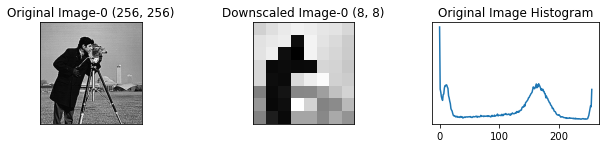

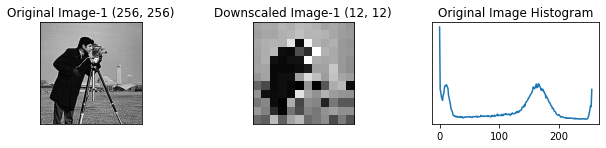

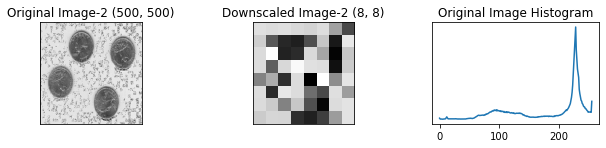

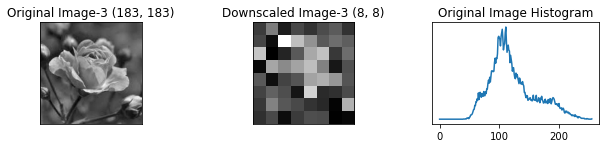

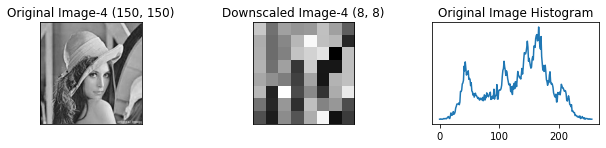

In [2]:
image_paths = [f'images/image{i + 1}.jpg' for i in range(4)]
org_images = [cv2.imread(path, 0) for path in image_paths]
bigger_image = cv2.imread('images/image1.jpg', 0)
org_images.insert(1, bigger_image)


def show_resize_images(org_image, i, size=(8, 8)):
    if i != 1:
        image = cv2.resize(org_image, size)
    else:
        image = cv2.resize(org_image, (12, 12))
    image = torch.tensor(image, dtype=torch.float32)
    h, _ = np.histogram(org_image, bins=256, range=(0, 255))
    fig, ax = plt.subplots(1, 3, figsize=(9, 2))
    fig.tight_layout()
    ax[0].imshow(org_image, cmap='gray')
    ax[1].imshow(image, cmap='gray')
    ax[0].set_yticks([])
    ax[0].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    ax[0].title.set_text('Original Image-{} {}'.format(i, org_image.shape))
    if i != 1:
        ax[1].title.set_text(f'Downscaled Image-{i} {size}')
    else:
        ax[1].title.set_text(f'Downscaled Image-{i} (12, 12)')

    ax[2].plot(h)
    ax[2].title.set_text('Original Image Histogram')
    ax[2].set_yticks([])
    return image, h


images = []
histograms = []
for i, org_image in enumerate(org_images):
    resized_image, h = show_resize_images(org_image, i, size=(8, 8))
    images.append(resized_image)
    histograms.append(h)


In the following we test three different encoding methods:

1. **Time to First Spike Encoding**
2. **Poisson Encoding**
2. **Numerical Encoding**

# Time2FirstSpikeEncoder

## Experiment #1 (Overall Behaviour)

$Time_{encode} = 100ms$

In the first experiment we additionally draw the mirrored activity plot, and the
original image's histogram to show that the mirrored activity plot (extracted from a 8x8 image)
is very similar to the image's histogram with
original size. This is quite interesting; although we are using a very small
 8x8 image, the whole image's statistics are encoded into a sparse set of spikes.
However, a large amount of information is lost in the process.

Note: In the following plots, each row represents an image and columns
are either showing the effect of changing an encoder's parameter or
different plots of that image.

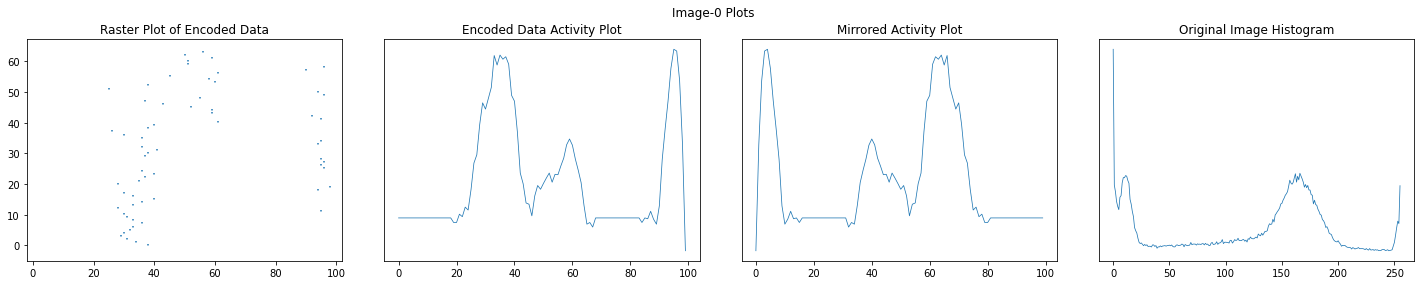

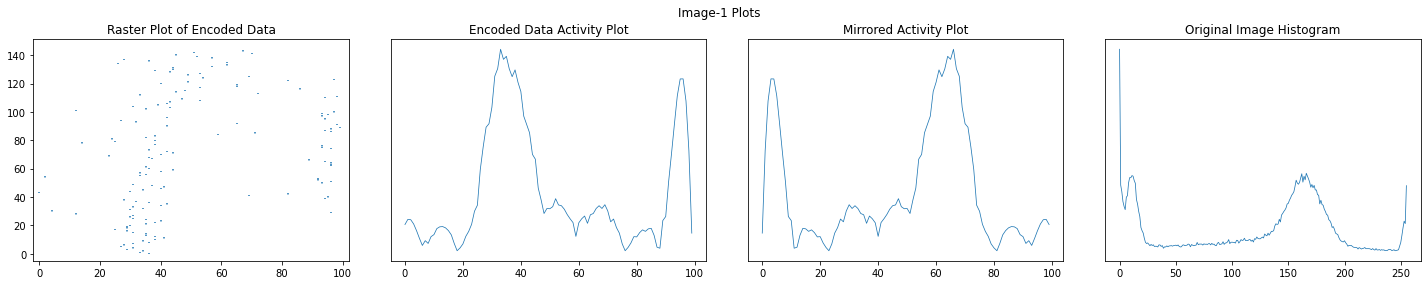

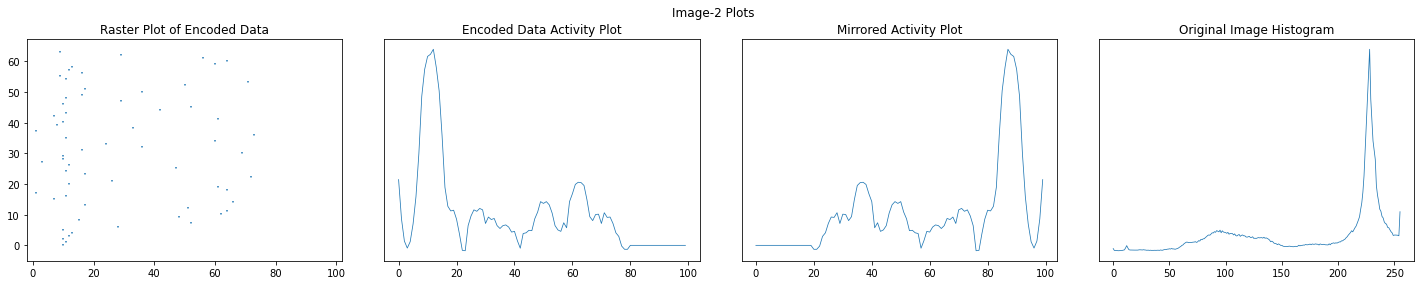

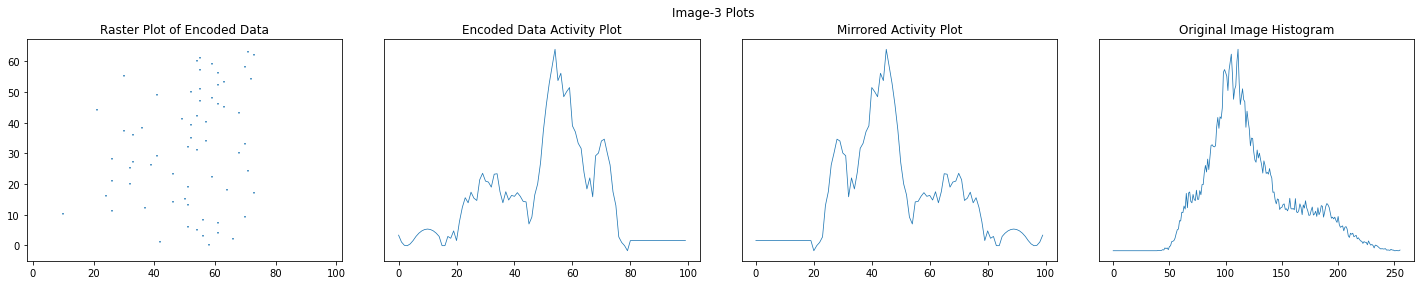

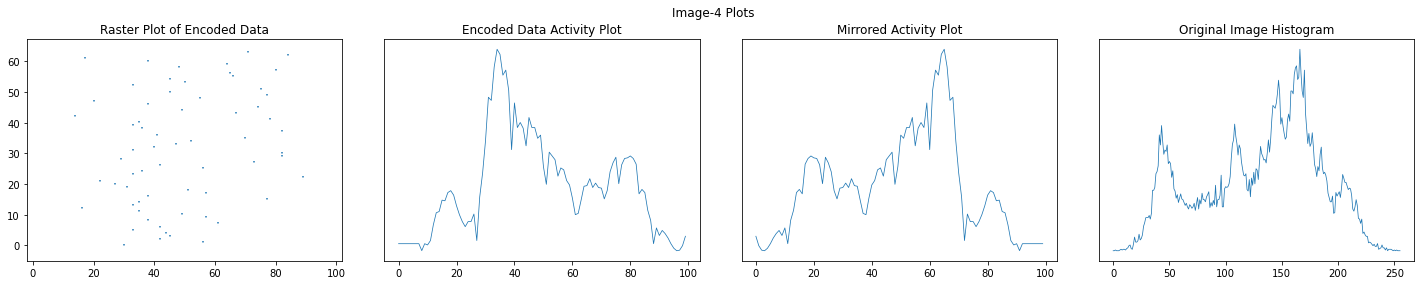

In [3]:
fig_size = (20, 4)
for i, image in enumerate(images):
    sim_time = 100
    t2f_encoder = Time2FirstSpikeEncoder(sim_time=sim_time)
    encoded_data = t2f_encoder(image)
    draw_encoded_data_plots(encoded_data, figsize=fig_size,
                            histogram=histograms[i],
                            title=f'Image-{i} Plots')

In the first image, dark pixels (values close to 0) are prevalent. So,
in the raster plot we see that a large portion of neurons spike at the end
of the raster plot. The other
peak in the image's histogram could be seen in the raster plot as well.
This explanation is also true for the other images.

## Experiment #2 (Encoding Time)

Now, we test different values for $Time_{encode}: [20, 50, 100, 500, 1000]$

Each column represent one $T_{encode}$ and each row represents one image.


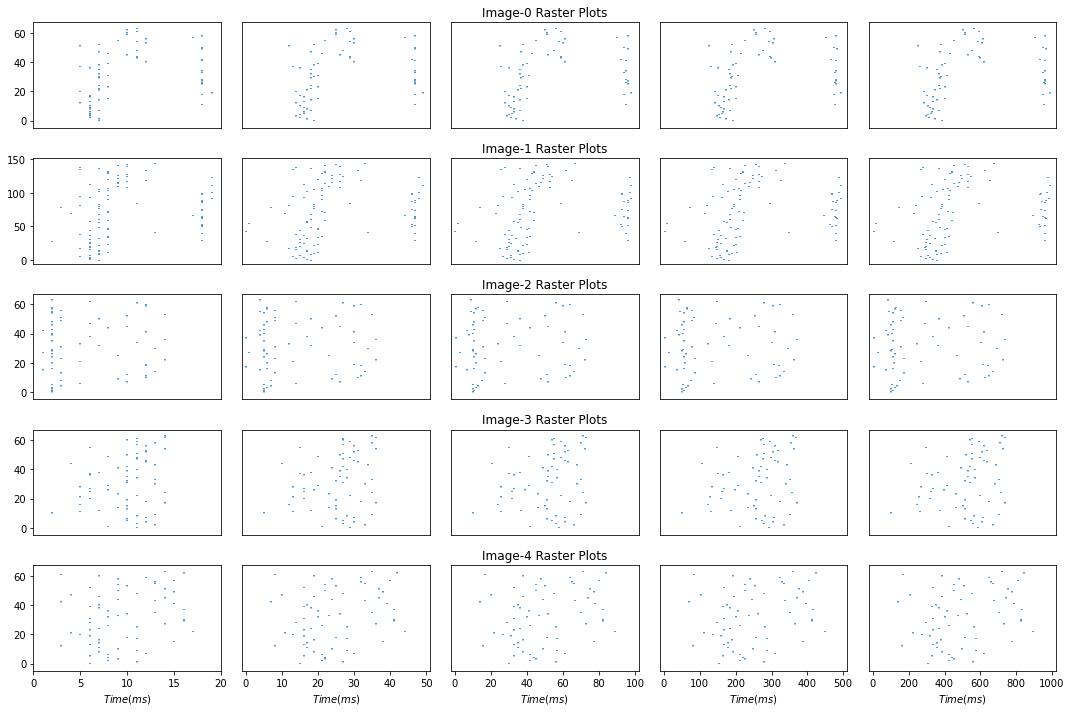

In [4]:
sim_times = [20, 50, 100, 500, 1000]
fig_size = (len(sim_times) * 3, len(images) * 2)
fig, ax = plt.subplots(len(images), len(sim_times), figsize=fig_size)
for i, image in enumerate(images):
    for j, sim_time in enumerate(sim_times):
        t2f_encoder = Time2FirstSpikeEncoder(sim_time=sim_time)
        encoded_data = t2f_encoder(image)
        if j != 0:
            ax[i, j].set_yticks([])
        if i != len(images) - 1:
            ax[i, j].set_xticks([])
        else:
            ax[i, j].set_xlabel('$Time(ms)$')
        raster_plot_encoded_data(encoded_data, ax=ax[i, j], title='')

for i in range(len(images)):
    ax[i, 2].title.set_text(f'Image-{i} Raster Plots')
fig.tight_layout()
plt.show()

From the above plots we conclude that if the encoding time becomes greater
than a certain value (about $20ms$ in our experiments), the output of encoding
will have the same shape regardless of the encoding time. To select a
particular encoding time, we should consider the sparsity of the activity we
need in the next layer of our network. By increasing the encoding time,
the same number of sparks will be distributed in more time. If the time becomes
too long, the effect of the spikes might not be sensed in the following layers,
as neurons will decay to their resting potentials exponentially.

# PoissonEncoder

In experiment #1 and #2, $r_{max} = 10$ , and in experiment #3,
the effect of changing this parameter is discussed.

## Experiment #1 (Overall Behaviour)

As we did for Time2FirstSpikeEncoder, we draw activity plot and its mirror,
along with the original's image histogram.

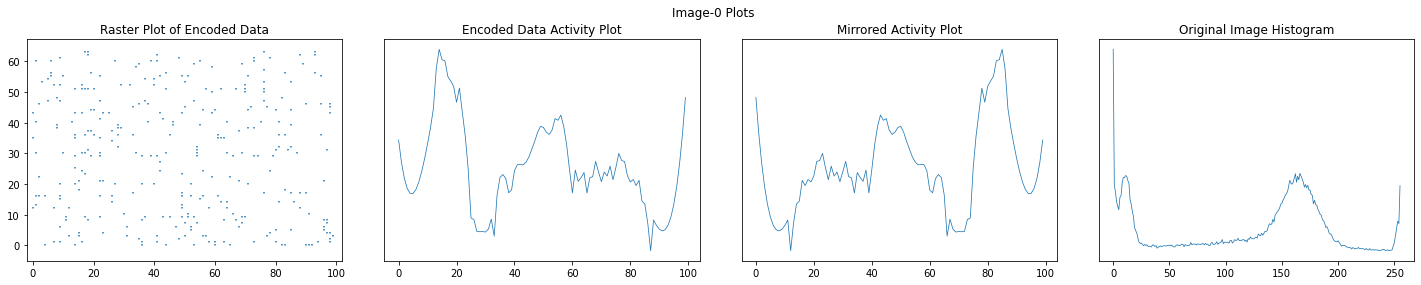

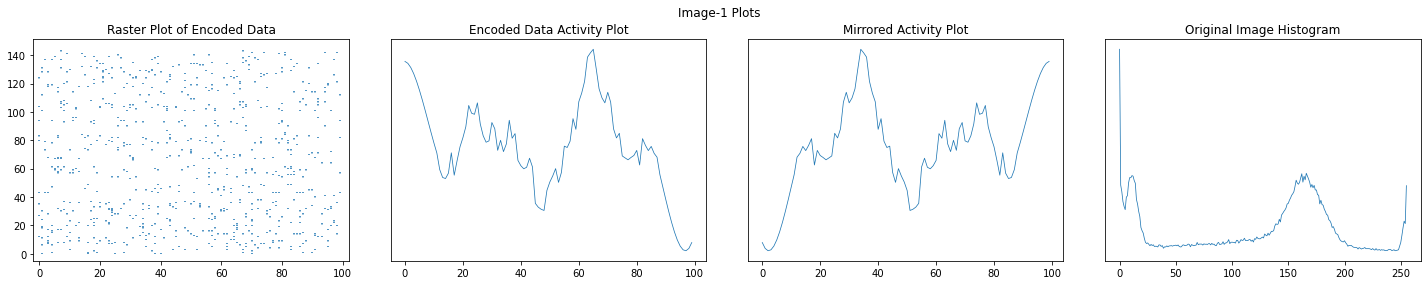

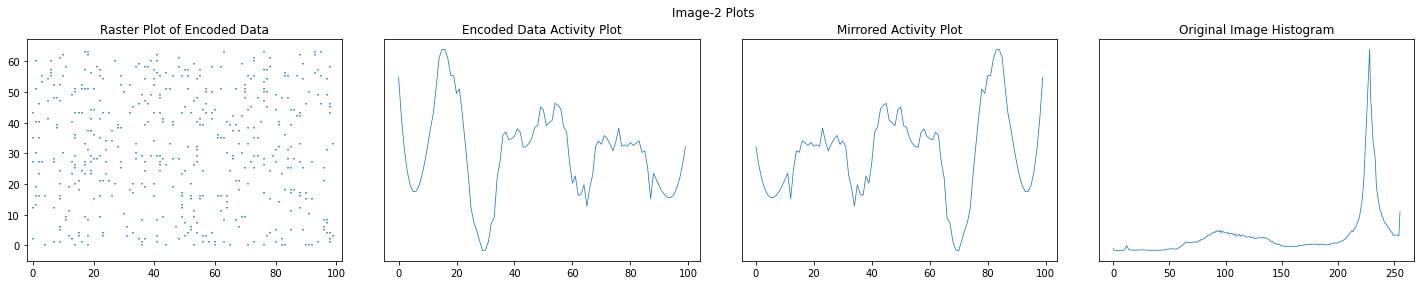

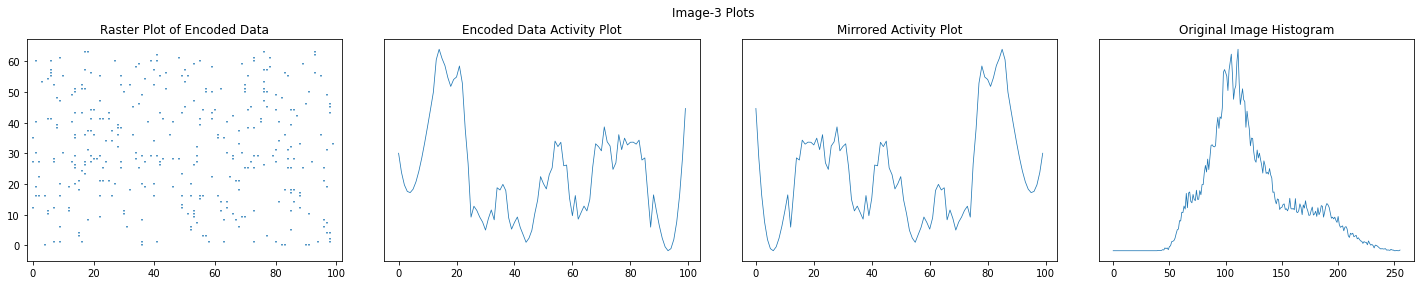

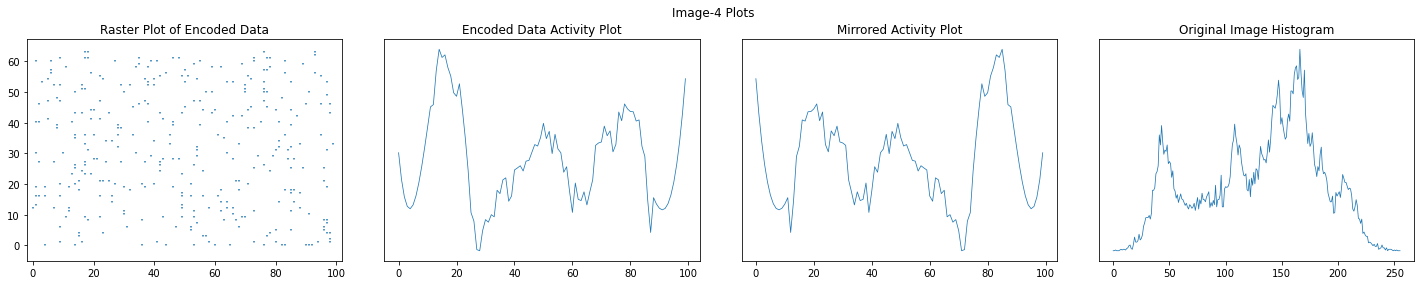

In [5]:
fig_size = (20, 4)
r_max = 10
for i, image in enumerate(images):
    sim_time = 100
    poisson_encoder = PoissonEncoder(sim_time=sim_time, rate_max=r_max)
    encoded_data = poisson_encoder(image)
    draw_encoded_data_plots(encoded_data, figsize=fig_size,
                            histogram=histograms[i],
                            title=f'Image-{i} Plots',
                            smooth_size=23)

By observing the above plots we see that the raster plots are not as sparse as
they are in Time-to-First-Spike-Encoding. As a result, the activity plots
are more noisy compared with the previous encoding method and less similar
to the original images' histograms. The good thing however, is that the spikes
are distributed in time more uniformly; so, the amount of lost information is lower than
the previous encoding method.

## Experiment #2 (Encoding Time)

Now, we test different values for $Time_{encode}: [20, 50, 100, 500, 1000]$


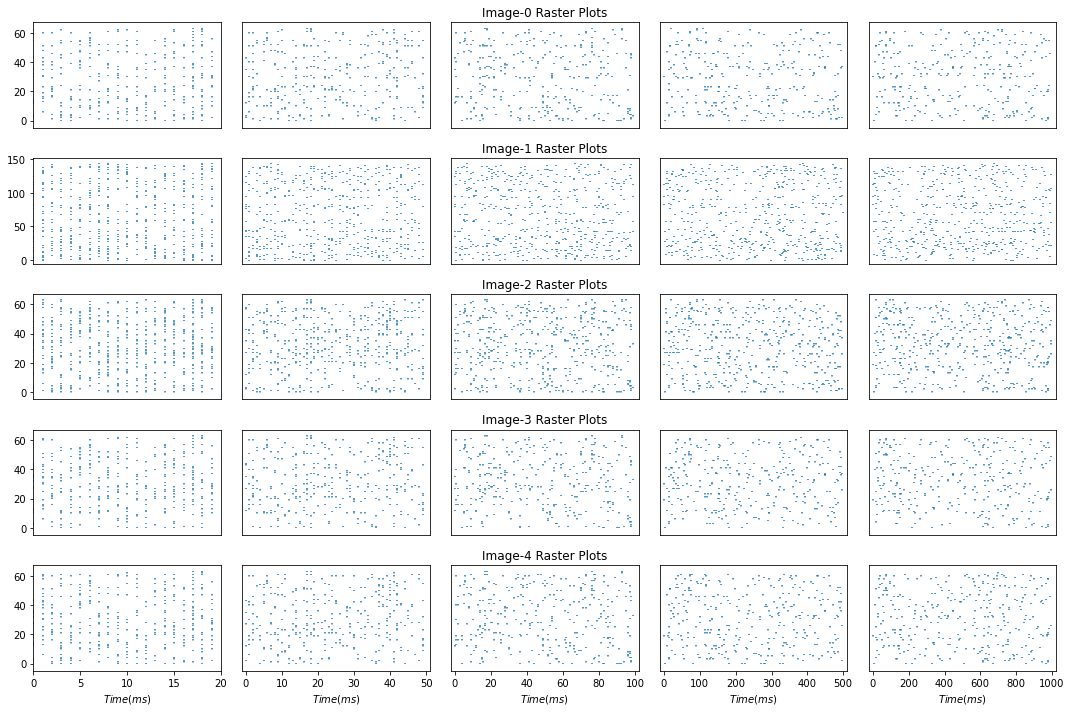

In [6]:
sim_times = [20, 50, 100, 500, 1000]
fig_size = (len(sim_times) * 3, len(images) * 2)
fig, ax = plt.subplots(len(images), len(sim_times), figsize=fig_size)
for i, image in enumerate(images):
    for j, sim_time in enumerate(sim_times):
        poisson_encoder = PoissonEncoder(sim_time=sim_time, rate_max=r_max)
        encoded_data = poisson_encoder(image)
        if j != 0:
            ax[i, j].set_yticks([])
        if i != len(images) - 1:
            ax[i, j].set_xticks([])
        else:
            ax[i, j].set_xlabel('$Time(ms)$')
        raster_plot_encoded_data(encoded_data, ax=ax[i, j], title='')

for i in range(len(images)):
    ax[i, 2].title.set_text(f'Image-{i} Raster Plots')
fig.tight_layout()
plt.show()

Again by increasing the encoding time, after a certain encoding time, the overall
shape of the raster plots are preserved, and only the sparsity of the spikes increases.
If the encoding time is too short, the encoder does not generate a
good representation of data.

## Experiment #3 ($r_{max}$)

Here, we fix the encoding time to $100ms$, and test the results of
the encoding with the following values of $r_{max}$: $[5, 20, 50, 75, 100]$

Each row represents an image, and each column represents $r_{max}$.

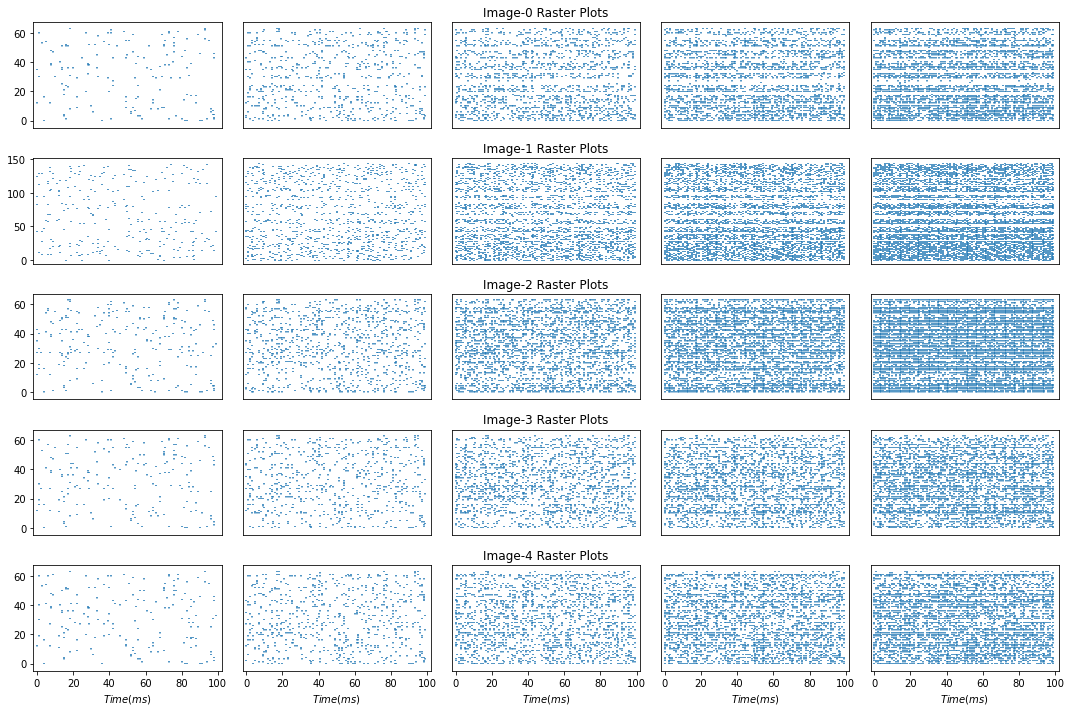

In [7]:
r_maxes = [5, 20, 50, 75, 100]
fig_size = (len(r_maxes) * 3, len(images) * 2)
fig, ax = plt.subplots(len(images), len(r_maxes), figsize=fig_size)
num_spikes = []
for i, image in enumerate(images):
    num_spikes.append([])
    for j, r_max in enumerate(r_maxes):
        poisson_encoder = PoissonEncoder(sim_time=100, rate_max=r_max)
        encoded_data = poisson_encoder(image)
        if j != 0:
            ax[i, j].set_yticks([])
        if i != len(images) - 1:
            ax[i, j].set_xticks([])
        else:
            ax[i, j].set_xlabel('$Time(ms)$')
        raster_plot_encoded_data(encoded_data, ax=ax[i, j], title='')
        num_spikes[i].append(encoded_data.sum())

for i in range(len(images)):
    ax[i, 2].title.set_text(f'Image-{i} Raster Plots')

fig.tight_layout()
plt.show()

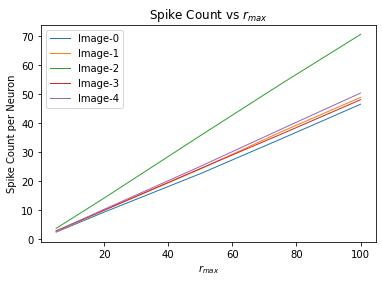

In [8]:
for i in range(len(images)):
    scale = 64 if i != 1 else 144
    n_spikes = [x / scale for x in num_spikes[i]]
    plt.plot(r_maxes, n_spikes, label=f'Image-{i}', linewidth=1)

plt.legend()
plt.xlabel('$r_{{max}}$')
plt.ylabel('Spike Count per Neuron')
plt.title('Spike Count vs $r_{{max}}$')
plt.show()

We see that by increasing the $r_{max}$ the total amount of spikes will increase
linearly. The slope of the line depends on the image's histogram.
The image with more pixels' of high intensity has the line with higher slope
(Image-2).
The overall shape of the raster plots however, is not changing with changing
$r_{max}$.

# PositionEncoder (NumericalEncoder)

This encoder uses multiple gaussian functions in order to encode a certain value.
If the value intersect with a gaussian with high height, it means that the
neuron corresponding to that gaussian should spike faster than the others.
Also, a threshold is set to determine which intersections should contribute to encoding.
If the intersection's height is lower than this threshold, we ignore the spike
for that neuron. This way, we ignore the gaussians whose contribution to the
encoding is minimal. Otherwise, there would be a peak at the end of raster plots,
as all neurons with low contribution will spike then. The threshold is fixed
to $0.95$ for all experiments. It means that the intersection point's height
should be greater than $0.95$ to be considered valid.

## Experiment #1 (Overall Behaviour)

$n_{neurons} = 10$

$\sigma_{gaussian} = 50$

Since we have $n_{neurons} = 10$, the total amount of neurons in the raster plot
for 8x8 images is: $8*8*10=640$. All the neurons corresponding to the same pixel,
are put next to each other in the raster plots.

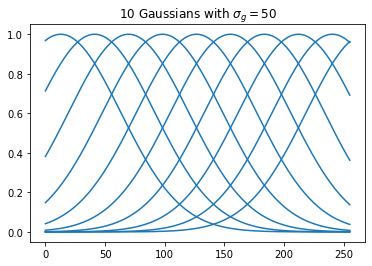

In [9]:
n_neurons = 10
sigma = 50
sim_time = 100
position_encoder = PositionEncoder(sim_time=sim_time,
                                   n_neurons=n_neurons,
                                   gaussian_sigma=sigma,)
gaussians = position_encoder.gaussians
x = np.linspace(0, 255, len(gaussians[0]))
for g in gaussians:
    plt.plot(x, g, c="C0")
plt.title('{} Gaussians with $\sigma_g = {}$'.format(len(gaussians), sigma))
plt.show()


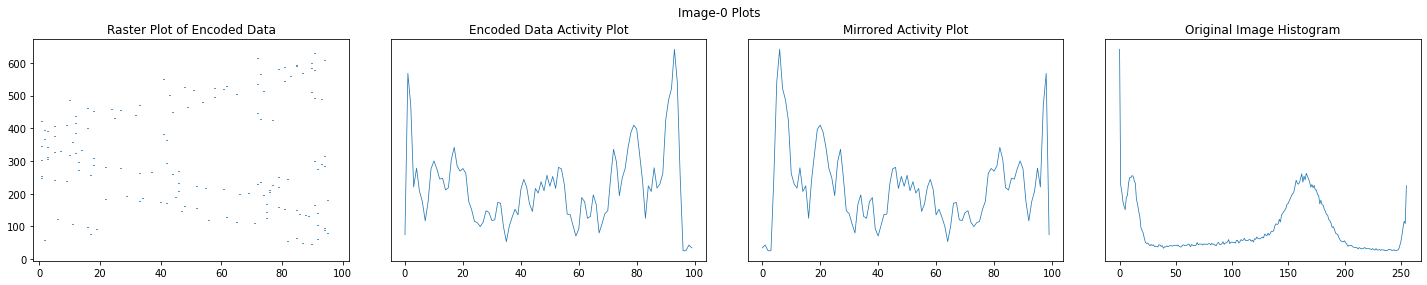

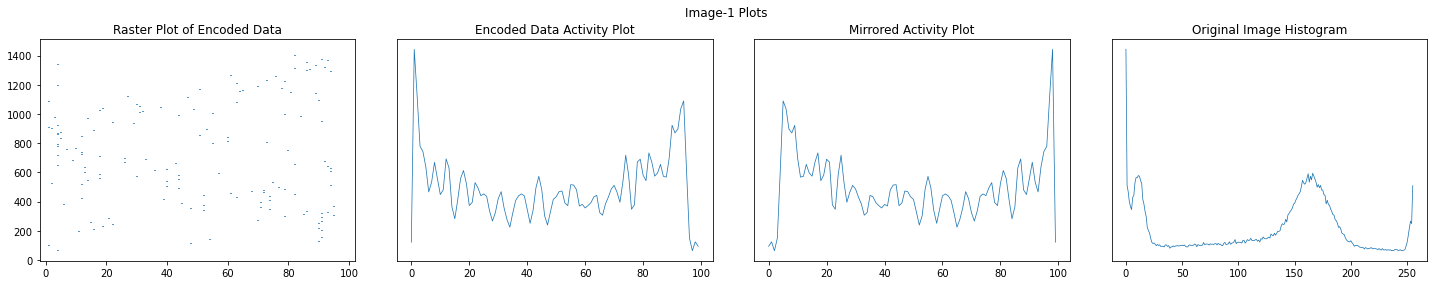

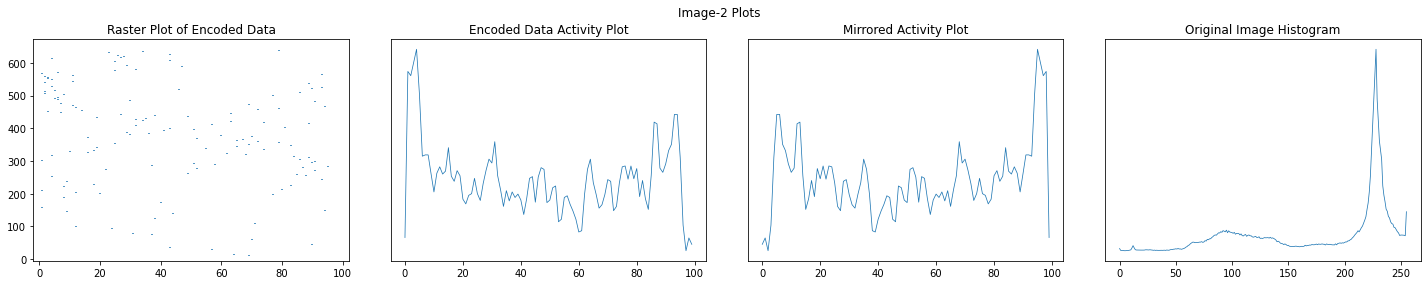

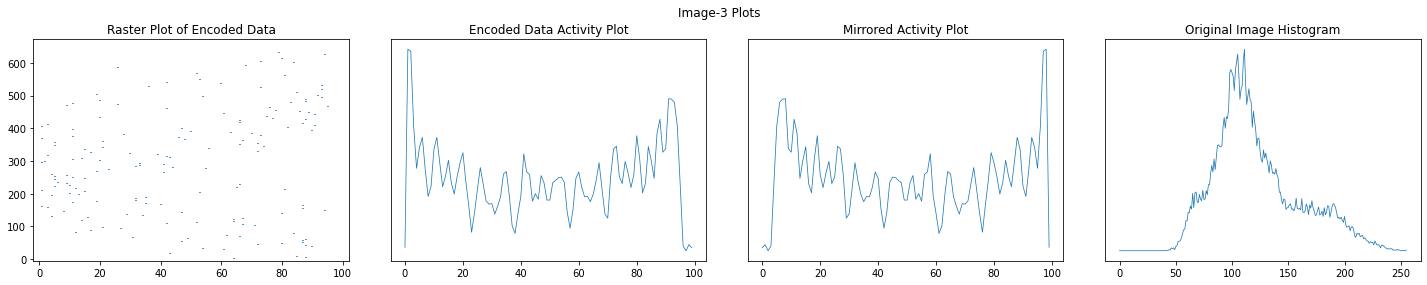

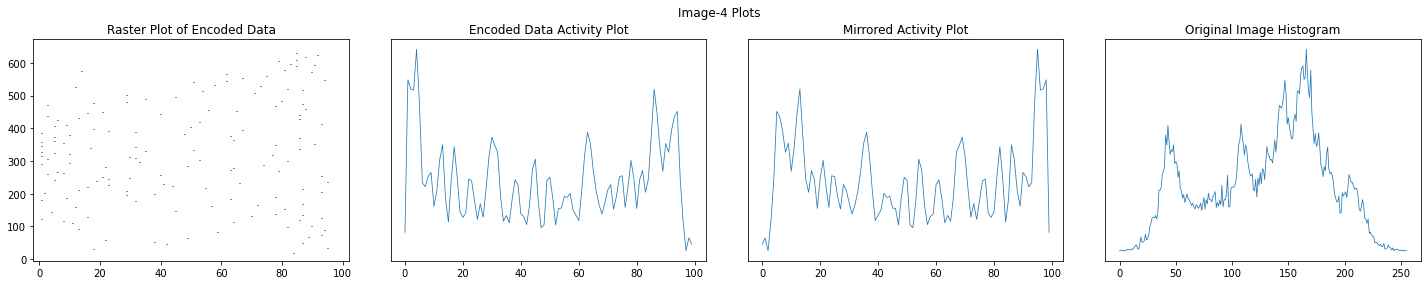

In [10]:
fig_size = (20, 4)
for i, image in enumerate(images):
    sim_time = 100
    position_encoder = PositionEncoder(sim_time=sim_time,
                                       n_neurons=n_neurons,
                                       gaussian_sigma=sigma,
                                       )
    encoded_data = position_encoder(image)
    gaussians = position_encoder.gaussians
    draw_encoded_data_plots(encoded_data, figsize=fig_size,
                            histogram=histograms[i],
                            title=f'Image-{i} Plots',
                            smooth_size=5)

The above plots indicate that unlike the two previous encoding methods,
the activity plots are not similar to the histogram of image. This is due
to the fact that this encoding method is inherently using different approach
to encode the pixel intensities. Unlike Time2FirstSpike, the spikes
are almost uniformly distributed in time.


## Experiment #2 (Encoding Time)
Now, we test different values for $Time_{encode}: [20, 50, 100, 200]$

Each row represent one image, and each column represent the encoding time parameter.

$n_{neurons} = 10$

$\sigma_{gaussian} = 50$

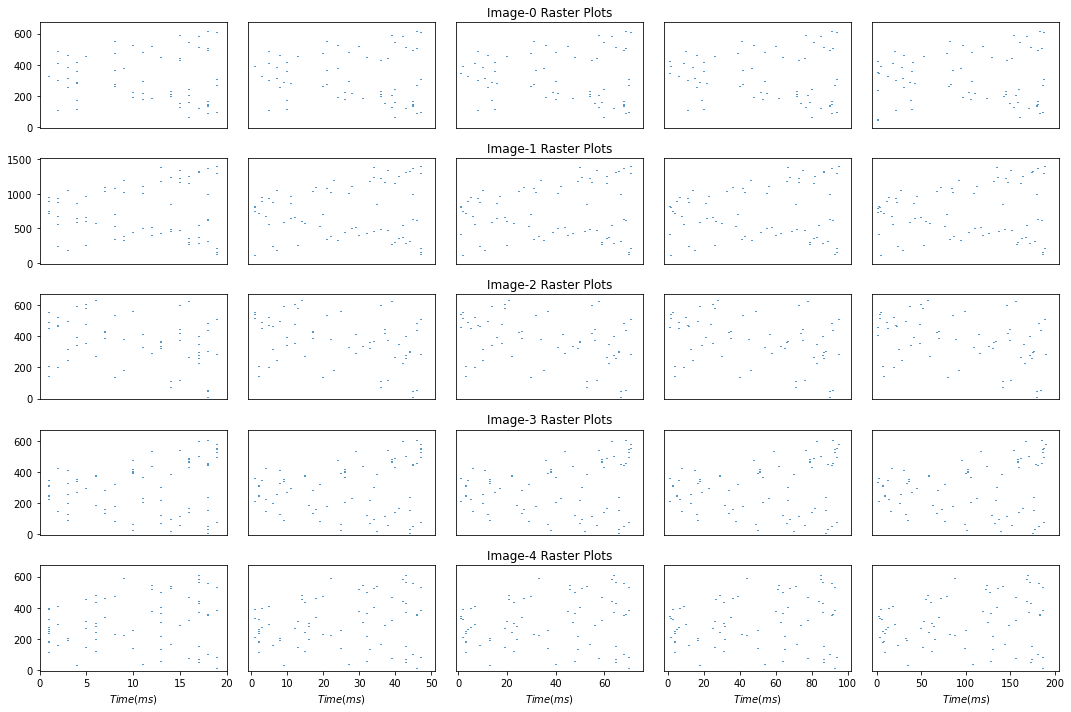

In [11]:
sim_times = [20, 50, 75, 100, 200]
fig_size = (len(sim_times) * 3, len(images) * 2)
fig, ax = plt.subplots(len(images), len(sim_times), figsize=fig_size)
for i, image in enumerate(images):
    for j, sim_time in enumerate(sim_times):
        position_encoder = PositionEncoder(sim_time=sim_time,
                                           n_neurons=10,
                                           gaussian_sigma=50)
        encoded_data = position_encoder(image)
        if j != 0:
            ax[i, j].set_yticks([])
        if i != len(images) - 1:
            ax[i, j].set_xticks([])
        else:
            ax[i, j].set_xlabel('$Time(ms)$')
        raster_plot_encoded_data(encoded_data, ax=ax[i, j], title='')

for i in range(len(images)):
    ax[i, 2].title.set_text(f'Image-{i} Raster Plots')
fig.tight_layout()
plt.show()

The result is the same with the other encoding methods when we tested changing
the encoding time. Only the sparsity of the output is affected not the shape.

## Experiment #3 (Number of Neurons)

Now, we test different values for $n_{neurons}: [7, 10, 20]$

Each column represents one of the tested parameters.

$Time_{encoding} = 50ms$

$\sigma_{gaussian} = 50$

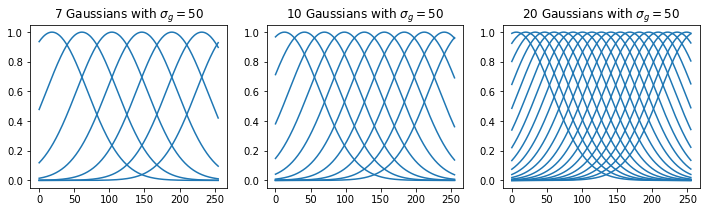

In [12]:
n_neurons = [7, 10, 20]
sigma = 50
fig, ax = plt.subplots(1, len(n_neurons), figsize=(12, 3))
for j, n in enumerate(n_neurons):
    position_encoder = PositionEncoder(sim_time=50,
                                       n_neurons=n,
                                       gaussian_sigma=sigma)
    x = np.linspace(0, 255, len(position_encoder.gaussians[0]))
    for g in position_encoder.gaussians:
        ax[j].plot(x, g, "C0")
    ax[j].title.set_text(
        '{} Gaussians with $\sigma_g = {}$'.format(n, sigma)
    )

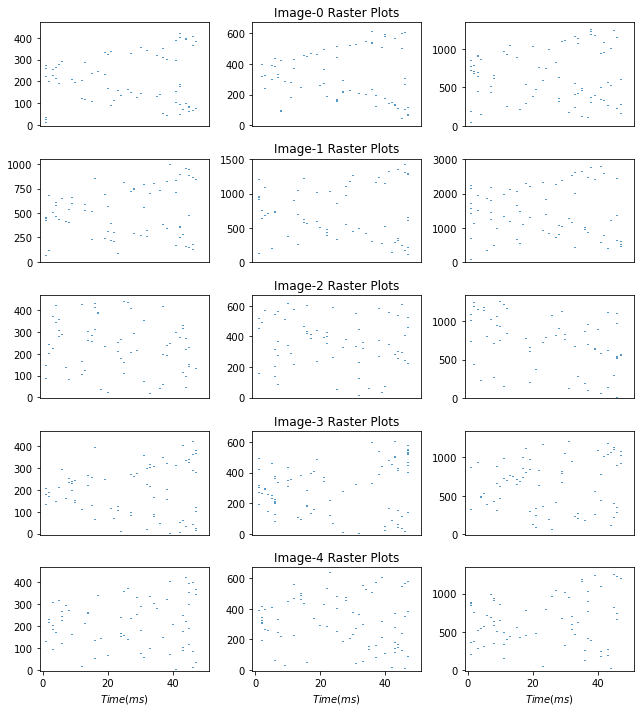

In [13]:
fig_size = (len(n_neurons) * 3, len(images) * 2)
fig, ax = plt.subplots(len(images), len(n_neurons), figsize=fig_size)
num_spikes = []
for i, image in enumerate(images):
    num_spikes.append([])
    for j, n in enumerate(n_neurons):
        position_encoder = PositionEncoder(sim_time=50,
                                           n_neurons=n,
                                           gaussian_sigma=50)
        encoded_data = position_encoder(image)
        if i != len(images) - 1:
            ax[i, j].set_xticks([])
        else:
            ax[i, j].set_xlabel('$Time(ms)$')
        raster_plot_encoded_data(encoded_data, ax=ax[i, j], title='')
        num_spikes[i].append(encoded_data.sum())

for i in range(len(images)):
    ax[i, 1].title.set_text(f'Image-{i} Raster Plots')
fig.tight_layout()
plt.show()

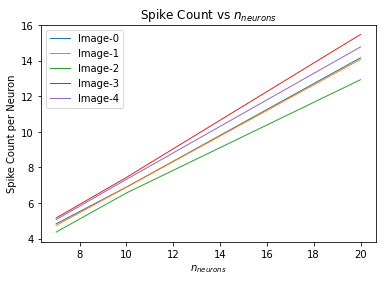

In [14]:
for i in range(len(images)):
    scale = 64 if i != 1 else 144
    n_spikes = [x / scale for x in num_spikes[i]]
    plt.plot(n_neurons, n_spikes, label=f'Image-{i}', linewidth=1)

plt.legend()
plt.xlabel('$n_{{neurons}}$')
plt.ylabel('Spike Count per Neuron')
plt.title('Spike Count vs $n_{{neurons}}$')
plt.show()

We see that the number of neurons increases the total spike count linearly in
each case. The slop of the line depends on the input image.
The shape of the raster plot changes slightly by changing the number of neurons,
but the overall shape is preserved.

## Experiment #4 ($\sigma_{gaussian}$)

Each column represents a $\sigma_g$, and the rows represent the images.

$n_{neurons}=10$

$time_{encoding} = 50ms$

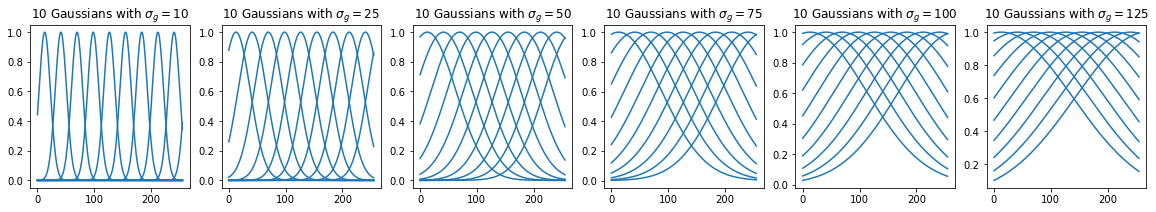

In [15]:
sigma_values = [10, 25, 50, 75, 100, 125]
sigma = 50
fig, ax = plt.subplots(1, len(sigma_values), figsize=(20, 3))
for j, s in enumerate(sigma_values):
    position_encoder = PositionEncoder(sim_time=50,
                                       n_neurons=10,
                                       gaussian_sigma=s)
    x = np.linspace(0, 255, len(position_encoder.gaussians[0]))
    for g in position_encoder.gaussians:
        ax[j].plot(x, g, "C0")
    ax[j].title.set_text(
        '{} Gaussians with $\sigma_g = {}$'.format(10, s)
    )

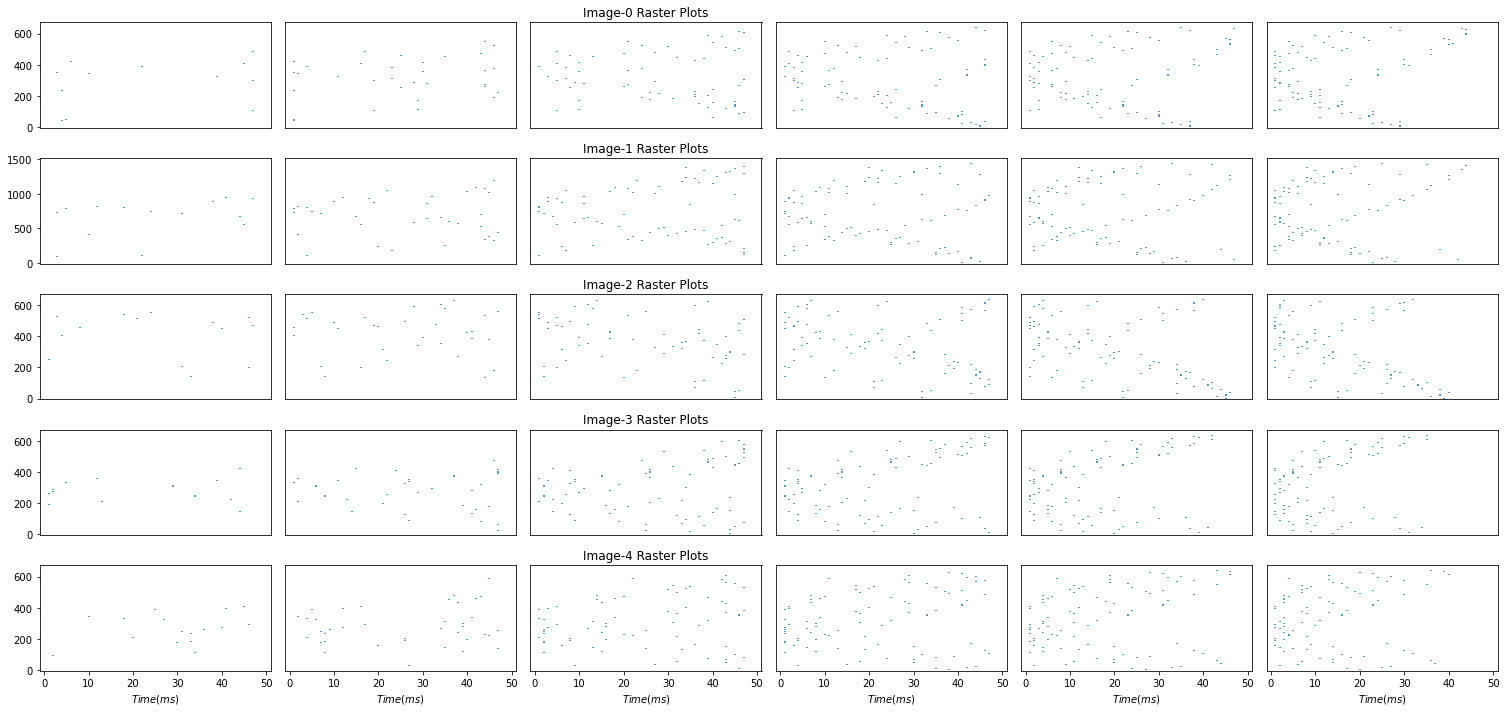

In [16]:
fig_size = (len(sigma_values) * 3.5, len(images) * 2)
fig, ax = plt.subplots(len(images), len(sigma_values), figsize=fig_size)
num_spikes = []
for i, image in enumerate(images):
    num_spikes.append([])
    for j, s in enumerate(sigma_values):
        position_encoder = PositionEncoder(sim_time=50,
                                           n_neurons=10,
                                           gaussian_sigma=s)
        encoded_data = position_encoder(image)
        if j != 0:
            ax[i, j].set_yticks([])
        if i != len(images) - 1:
            ax[i, j].set_xticks([])
        else:
            ax[i, j].set_xlabel('$Time(ms)$')
        raster_plot_encoded_data(encoded_data, ax=ax[i, j], title='')
        num_spikes[i].append(encoded_data.sum())

for i in range(len(images)):
    ax[i, 2].title.set_text(f'Image-{i} Raster Plots')
fig.tight_layout()
plt.show()

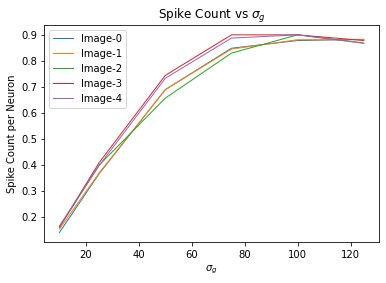

In [17]:
for i in range(len(images)):
    scale = 640 if i != 1 else 1440
    n_spikes = [x / scale for x in num_spikes[i]]
    plt.plot(sigma_values, n_spikes, label=f'Image-{i}', linewidth=1)

plt.legend()
plt.xlabel('$\sigma_{{g}}$')
plt.ylabel('Spike Count per Neuron')
plt.title('Spike Count vs $\sigma_{{g}}$')
plt.show()

From the above plots, we conclude that increasing $\sigma_g$, increases the
number of spikes increases but not linearly. The slope of the plot vanishes
after a certain point, and the plot will plateau.
The overall shape of the plots however, are remained unchanged.

# Summary

We conclude the following results from all experiments:

1. Changing the $Time_{encoding}$ only affects the sparsity of the encoded
data through time. Increasing this parameter will result in more sparse raster plot.
The overall shape of the plots are preserved. This observation is the same for
all three encoding methods.
2. The scale of the image does not affect the encoding besides that the
number of neurons for encoding would be different. We calculated the spike counts
per neuron for different images and saw that the first and second images
spike count per neuron are exactly the same. These two images are only different
in their size. (8x8 vs 12x12)
3. In PoissonEncoder, increasing $r_{max}$ increases the spike counts linearly.
The shape of the raster plot is preserved.
4. In PositionEncoder, increasing $n_{neurons}$ increases the spike count linearly.
The shape of the raster plot is preserved.
5.  In PositionEncoder, increasing $\sigma_{gaussian}$ increases the spike count in
a non-linear manner. The slope of the spike-count vs $\sigma_{gaussian}$ plot
will converge to zero slowly (the plot will plateau).
6. In Time2FirstSpikeEncoder and PoissonEncoder, the mirrored plot of
 output activity is mimicking the original image's histogram. The Time2FirstSpikeEncoder
 mirrored activity is more similar to the histogram compared with PoissonEncoder.
7. Time2FirstSpikeEncoder and PoissonEncoder tend to encode the statistics of
the image (similar to histogram) throughout the time. The PositionEncoder encodes the intensity of
each pixel in time.
